In [1]:
import zipfile
import os
import shutil
import random

# STEP 1: Unzip your dataset
zip_path = "/content/archive.zip"
extract_path = "/content/brain_tumor_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

print("Extraction done.")

Extraction done.


In [ ]:
import os

# Look inside the unzipped directory
for root, dirs, files in os.walk("/content/brain_tumor_data"):
    print("📁", root)
    for d in dirs:
        print("  📂", d)
    for f in files[:5]:  # just print 5 sample files
        print("  📄", f)
    break  # just look at the top-level for now


📁 /content/brain_tumor_data
  📂 Training
  📂 Testing


In [ ]:
import os

for root, dirs, files in os.walk("/content/brain_tumor_data"):
    print("📁", root)
    for d in dirs:
        print("  📂", d)
    for f in files[:5]:
        print("  📄", f)
    break


📁 /content/brain_tumor_data
  📂 Training
  📂 Testing


In [ ]:
import shutil

for folder in ['yes', 'no']:
    yes_path = f"/content/data/train/{folder}"
    val_path = f"/content/data/val/{folder}"

    if os.path.exists(yes_path):
        shutil.rmtree(yes_path)
    if os.path.exists(val_path):
        shutil.rmtree(val_path)

print("✅ Removed 'yes' and 'no' folders.")


✅ Removed 'yes' and 'no' folders.


In [ ]:
import os
import shutil
import random

# Define paths
original_dataset_dir = "/content/brain_tumor_data/Training"
base_dir = "/content/data"

# List class labels (folder names)
labels = ['glioma', 'meningioma', 'pituitary', 'notumor']

# Create train/val directories
for label in labels:
    os.makedirs(os.path.join(base_dir, 'train', label), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'val', label), exist_ok=True)

# Split each class folder into train/val
for label in labels:
    img_dir = os.path.join(original_dataset_dir, label)
    all_files = os.listdir(img_dir)
    random.shuffle(all_files)

    split_idx = int(0.8 * len(all_files))
    train_files = all_files[:split_idx]
    val_files = all_files[split_idx:]

    for file in train_files:
        shutil.copy(os.path.join(img_dir, file), os.path.join(base_dir, 'train', label, file))

    for file in val_files:
        shutil.copy(os.path.join(img_dir, file), os.path.join(base_dir, 'val', label, file))

print("✅ Multi-class dataset split into train/val.")


✅ Multi-class dataset split into train/val.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create image data generators for normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,       # Random rotation (degrees)
    width_shift_range=0.1,   # Horizontal shift
    height_shift_range=0.1,  # Vertical shift
    zoom_range=0.1,          # Zoom in/out
    shear_range=0.1,         # Shear transform
    horizontal_flip=True,    # Flip image horizontally
    fill_mode='nearest'
      )      # Fill in missing pixels
val_datagen = ImageDataGenerator(rescale=1./255)

# Define image generators for training and validation
train_generator = train_datagen.flow_from_directory(
    "/content/data/train",
    target_size=(128, 128),        # Resize images
    batch_size=32,
    class_mode='categorical'       # MULTI-CLASS classification
)

val_generator = val_datagen.flow_from_directory(
    "/content/data/val",
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)


Found 6006 images belonging to 4 classes.
Found 3847 images belonging to 4 classes.


In [ ]:
train_generator.class_indices


{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

input_layer = Input(shape=(128, 128, 3))

x = Conv2D(32, (3,3), padding='same', activation='relu', name="conv2d_0")(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Conv2D(64, (3,3), padding='same', activation='relu', name="conv2d_1")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Conv2D(128, (3,3), padding='same', activation='relu', name="conv2d_2")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)  # 4 classes

model = Model(inputs=input_layer, outputs=output)


| Layer | Typical Filters | Reasoning                                          |
| ----- | --------------- | -------------------------------------------------- |
| 1st   | 32              | Detects basic patterns: edges, gradients, corners  |
| 2nd   | 64              | Detects small shapes or parts of objects           |
| 3rd+  | 128 or 256+     | Detects complex structures and high-level patterns |


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',  # for multi-class classification
    metrics=['accuracy', Precision(), Recall(), AUC()]
)


In [ ]:
model.summary()


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_0 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,289,092 (16.36 MB)

 Trainable params: 4,288,644 (16.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


In [ ]:
#Adding class weights
from sklearn.utils import class_weight
import numpy as np

# Get class indices
labels = train_generator.classes  # numerical labels (0 to 3)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

# Convert to dict for model.fit()
class_weights = dict(enumerate(class_weights))


In [ ]:
#Saving Model
model.save("brain_tumor_cnn_model.h5")


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop],
    class_weight=class_weights
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 454s 2s/step - accuracy: 0.5556 - auc_3: 0.7943 - loss: 1.3522 - precision_3: 0.6104 - recall_3: 0.4521 - val_accuracy: 0.2529 - val_auc_3: 0.5085 - val_loss: 7.7504 - val_precision_3: 0.2527 - val_recall_3: 0.2516
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 404s 2s/step - accuracy: 0.6815 - auc_3: 0.8954 - loss: 0.7890 - precision_3: 0.7610 - recall_3: 0.5606 - val_accuracy: 0.6291 - val_auc_3: 0.8527 - val_loss: 1.2002 - val_precision_3: 0.6457 - val_recall_3: 0.6111
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 401s 2s/step - accuracy: 0.7215 - auc_3: 0.9128 - loss: 0.7235 - precision_3: 0.7897 - recall_3: 0.6227 - val_accuracy: 0.7993 - val_auc_3: 0.9576 - val_loss: 0.4955 - val_precision_3: 0.8536 - val_recall_3: 0.7289
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 402s 2s/step - accuracy: 0.7292 - auc_3: 0.9229 - loss: 0.6761 - precision_3: 0.7902 - recall_3: 0.6522 - val_accuracy: 0.8089 - val_auc_3: 0.9608 - val_loss: 0.4724 - val_precision_3: 0.8625 - v

Evaluating Model

In [ ]:
results = model.evaluate(val_generator)
print(f"Validation Loss: {results[0]:.4f}")
print(f"Validation Accuracy: {results[1]:.4f}")
print(f"Validation AUC: {results[2]:.4f}")


121/121 ━━━━━━━━━━━━━━━━━━━━ 50s 412ms/step - accuracy: 0.8274 - auc_3: 0.9634 - loss: 0.4603 - precision_3: 0.8449 - recall_3: 0.7965
Validation Loss: 0.4484
Validation Accdouracy: 0.8282
Validation AUC: 0.8497


In [ ]:
import numpy as np

# Predict probabilities for each class
pred_probs = model.predict(val_generator)
y_pred = np.argmax(pred_probs, axis=1)  # Predicted class indices
y_true = val_generator.classes           # True class indices


121/121 ━━━━━━━━━━━━━━━━━━━━ 50s 413ms/step


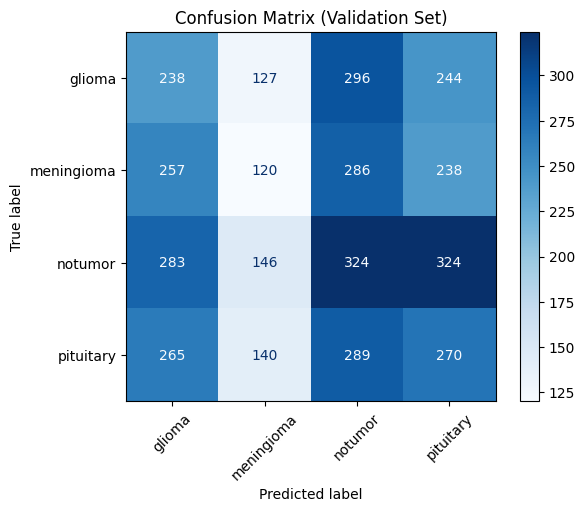

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
labels = list(val_generator.class_indices.keys())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Validation Set)")
plt.xticks(rotation=45)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


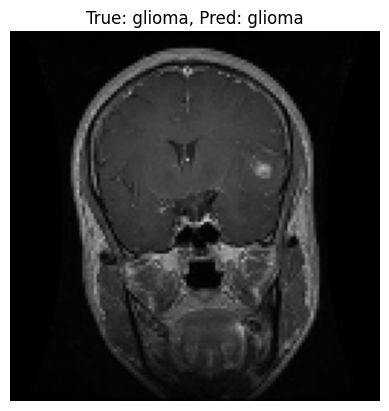

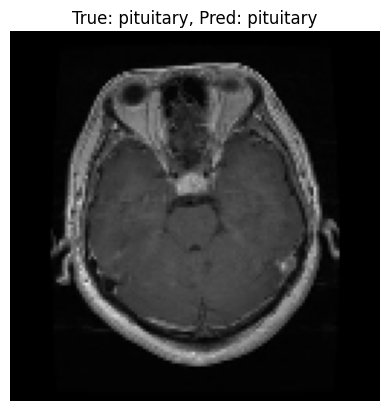

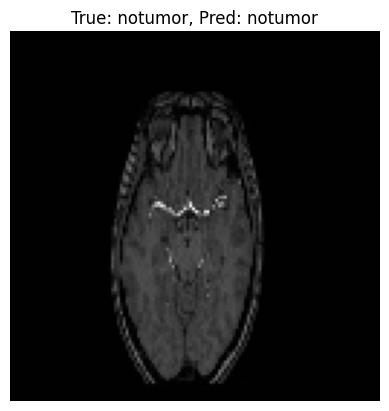

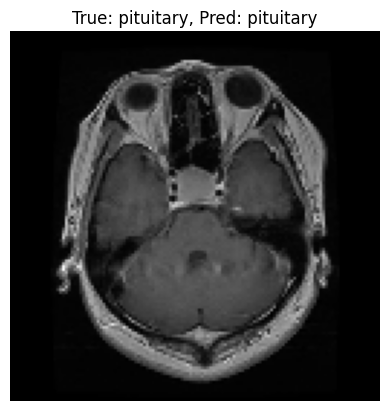

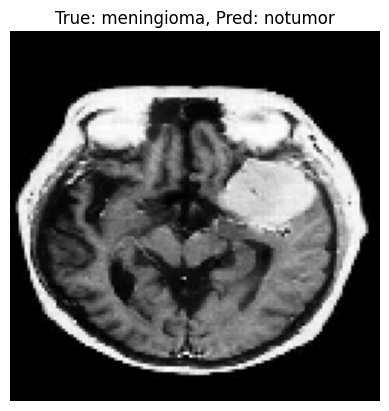

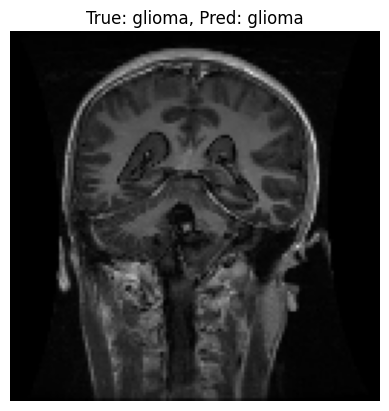

In [ ]:
import matplotlib.pyplot as plt

# Get a batch of images and labels from the generator
images, true_labels = next(val_generator)

# Predict on this batch
pred_batch = model.predict(images)
pred_classes = np.argmax(pred_batch, axis=1)
true_classes = np.argmax(true_labels, axis=1)

# Show first 6 predictions
for i in range(6):
    plt.imshow(images[i])
    plt.title(f"True: {labels[true_classes[i]]}, Pred: {labels[pred_classes[i]]}")
    plt.axis("off")
    plt.show()


Applying Grad-CAM

In [ ]:
# Reset the generator and get one batch
val_generator.reset()
images, labels = next(val_generator)

# Select one image
img = images[0]
img_array = np.expand_dims(img, axis=0)
pred_class = np.argmax(model.predict(img_array))
true_class = np.argmax(labels[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


In [ ]:
import numpy as np

dummy_input = np.random.random((1, 128, 128, 3))  # Assuming your model input is (128,128,3)
_ = model.predict(dummy_input)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


In [ ]:
#defining grad-CAM
import tensorflow as tf

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]

    # Gradients of the class output w.r.t. conv layer
    grads = tape.gradient(class_output, conv_outputs)

    # Mean intensity of gradients (importance of each filter)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply channels by importance weights
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_392']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


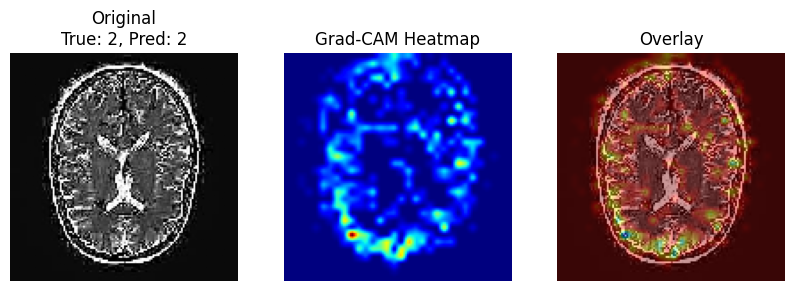

In [ ]:
#generating and overlaying heatmap
# Choose the name of the last convolutional layer
import cv2

last_conv_layer_name = "conv2d_2"

# Generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_class)

# Overlay heatmap on image
img_rgb = np.uint8(img * 255)
heatmap_resized = cv2.resize(heatmap, (img_rgb.shape[1], img_rgb.shape[0]))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img_rgb, 0.6, heatmap_colored, 0.4, 0)

# Display
plt.figure(figsize=(10,4))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title(f"Original\nTrue: {true_class}, Pred: {pred_class}")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(heatmap_resized, cmap='jet')
plt.title("Grad-CAM Heatmap")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(superimposed_img)
plt.title("Overlay")
plt.axis('off')
plt.show()


Comparing Performance to a Well-established model like MobileNetV2

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import Input


In [ ]:
input_shape = (128, 128, 3)  # match your resized image dimensions

base_model = MobileNetV2(include_top=False, input_shape=input_shape, weights='imagenet')
base_model.trainable = False  # freeze base

inputs = Input(shape=input_shape)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(4, activation='softmax')(x)  # 4 classes

mobilenet_model = Model(inputs, outputs)


In [ ]:
mobilenet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
)


In [ ]:
mobilenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    class_weight=class_weights  # optional
)


Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 154s 783ms/step - accuracy: 0.2578 - auc: 0.5119 - loss: 1.5504 - precision: 0.2698 - recall: 0.0678 - val_accuracy: 0.4396 - val_auc: 0.7006 - val_loss: 1.2666 - val_precision: 0.9540 - val_recall: 0.0647
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 145s 769ms/step - accuracy: 0.3394 - auc: 0.5988 - loss: 1.3637 - precision: 0.5680 - recall: 0.0633 - val_accuracy: 0.4333 - val_auc: 0.7571 - val_loss: 1.2043 - val_precision: 0.9537 - val_recall: 0.0910
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 143s 762ms/step - accuracy: 0.3877 - auc: 0.6563 - loss: 1.2818 - precision: 0.7741 - recall: 0.0845 - val_accuracy: 0.4396 - val_auc: 0.6990 - val_loss: 1.2094 - val_precision: 0.9241 - val_recall: 0.1742
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 143s 762ms/step - accuracy: 0.4095 - auc: 0.6871 - loss: 1.2452 - precision: 0.7876 - recall: 0.1154 - val_accuracy: 0.5997 - val_auc: 0.7948 - val_loss: 1.1324 - val_precision: 0.9296 - val_recall: 0.1339
Epoch 5/10
188/1